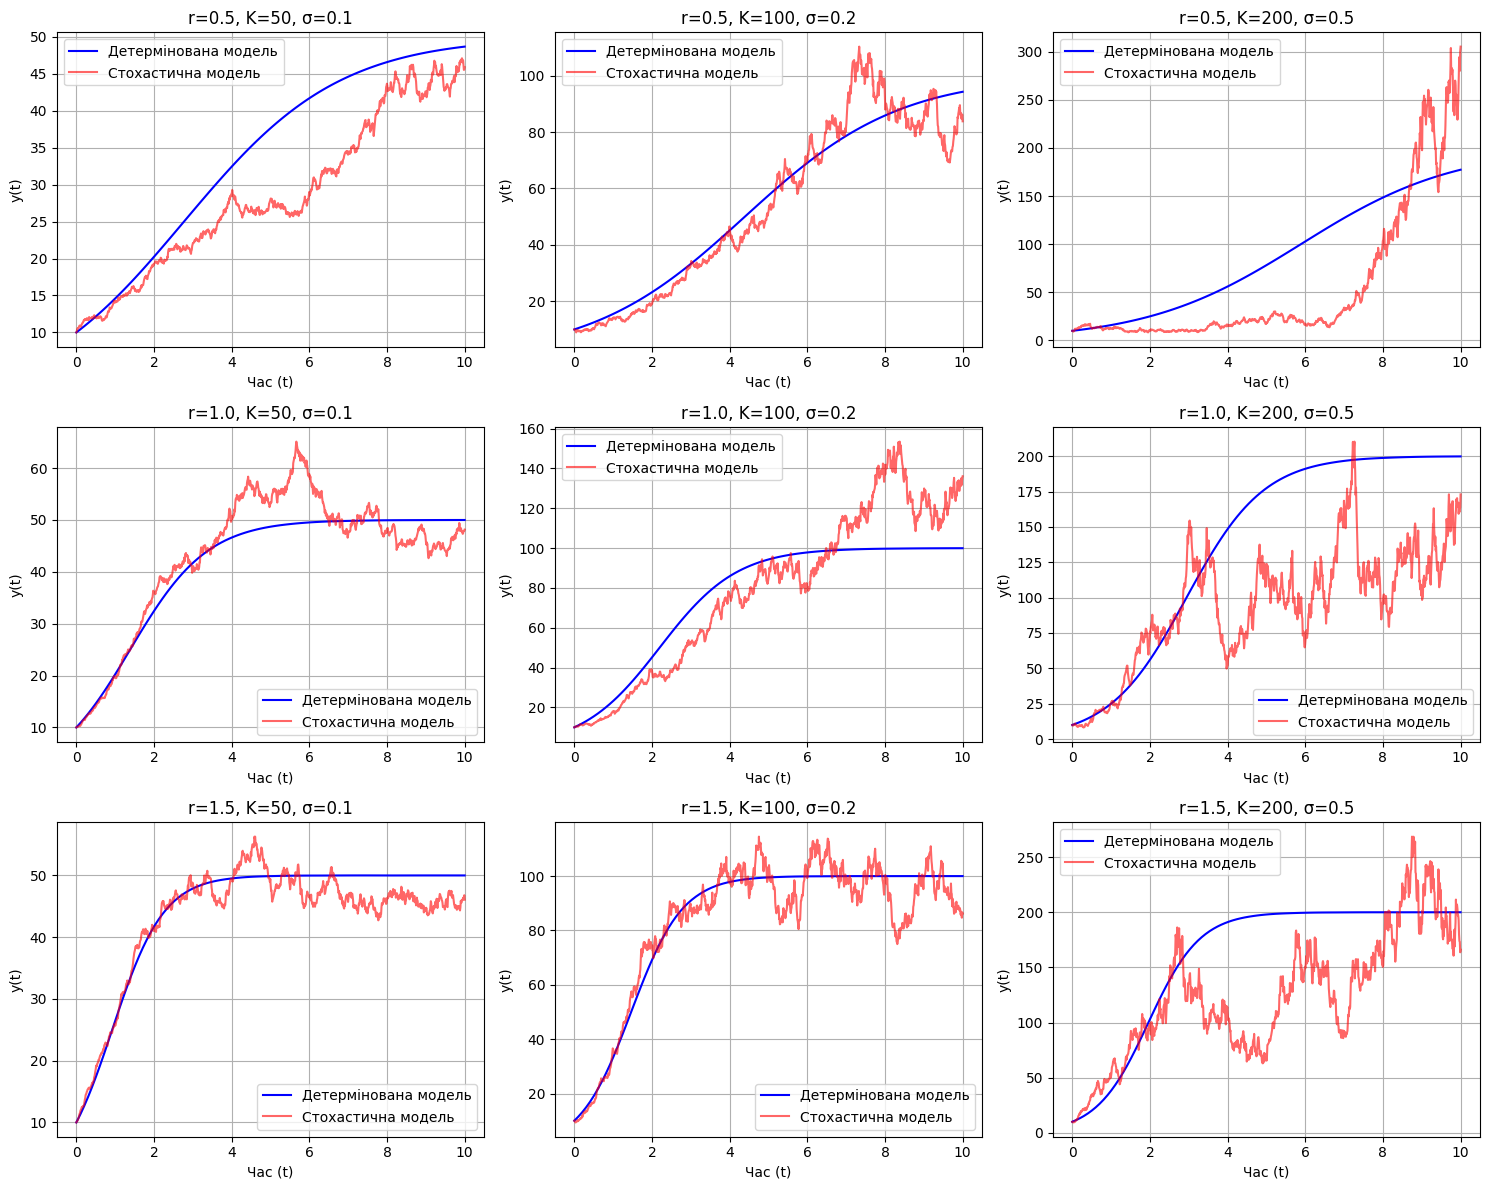

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Функція логістичної моделі
def logistic_model(t, y, r, K):
    return r * y * (1 - y / K)

# Функція для стохастичної моделі методом Euler–Maruyama
def stochastic_logistic(y0, r, K, sigma, T, n_steps):
    dt = T / n_steps
    t_stoch = np.linspace(0, T, n_steps)
    y_stoch = np.zeros(n_steps)
    y_stoch[0] = y0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        y_stoch[i] = y_stoch[i-1] + r * y_stoch[i-1] * (1 - y_stoch[i-1] / K) * dt + sigma * y_stoch[i-1] * dW
        y_stoch[i] = max(y_stoch[i], 0)  # Гарантуємо, що популяція не стає від'ємною

    return t_stoch, y_stoch

# Значення параметрів для аналізу чутливості
r_values = [0.5, 1.0, 1.5]  # Швидкість зростання популяції
K_values = [50, 100, 200]  # Місткість середовища
sigma_values = [0.1, 0.2, 0.5]  # Інтенсивність шуму

# Початкове значення та інтервал часу
y0 = 10.0
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)
T = t_span[1]
n_steps = 1000

# Візуалізація впливу параметрів
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, r in enumerate(r_values):
    for j, K in enumerate(K_values):
        # Розв'язок детермінованої моделі
        solution = solve_ivp(logistic_model, t_span, [y0], t_eval=t_eval, args=(r, K))
        y_det = solution.y[0]

        # Розв'язок стохастичної моделі
        sigma = sigma_values[j]  # Відповідність значень σ зміні K
        t_stoch, y_stoch = stochastic_logistic(y0, r, K, sigma, T, n_steps)

        # Побудова графіків
        ax = axes[i, j]
        ax.plot(t_eval, y_det, 'b-', label="Детермінована модель")
        ax.plot(t_stoch, y_stoch, 'r-', alpha=0.6, label="Стохастична модель")
        ax.set_title(f"r={r}, K={K}, σ={sigma}")
        ax.set_xlabel("Час (t)")
        ax.set_ylabel("y(t)")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


**Результати**

* При збільшенні $r$ популяція зростає швидше та досягає рівноважного стану раніше.

* Стохастична модель показує значні коливання для високих значень $r$, особливо на ранніх етапах.

* Чим більше $K$, тим більша рівноважна популяція.

* Стохастичний шум має більший вплив, коли $K$ мале, спричиняючи випадкові коливання.

* При малих $\sigma$ траєкторія стохастичної моделі майже збігається з детермінованою.

* При великих $\sigma$ популяція може зазнавати різких змін, що може навіть призвести до її вимирання на малих значеннях $K$.

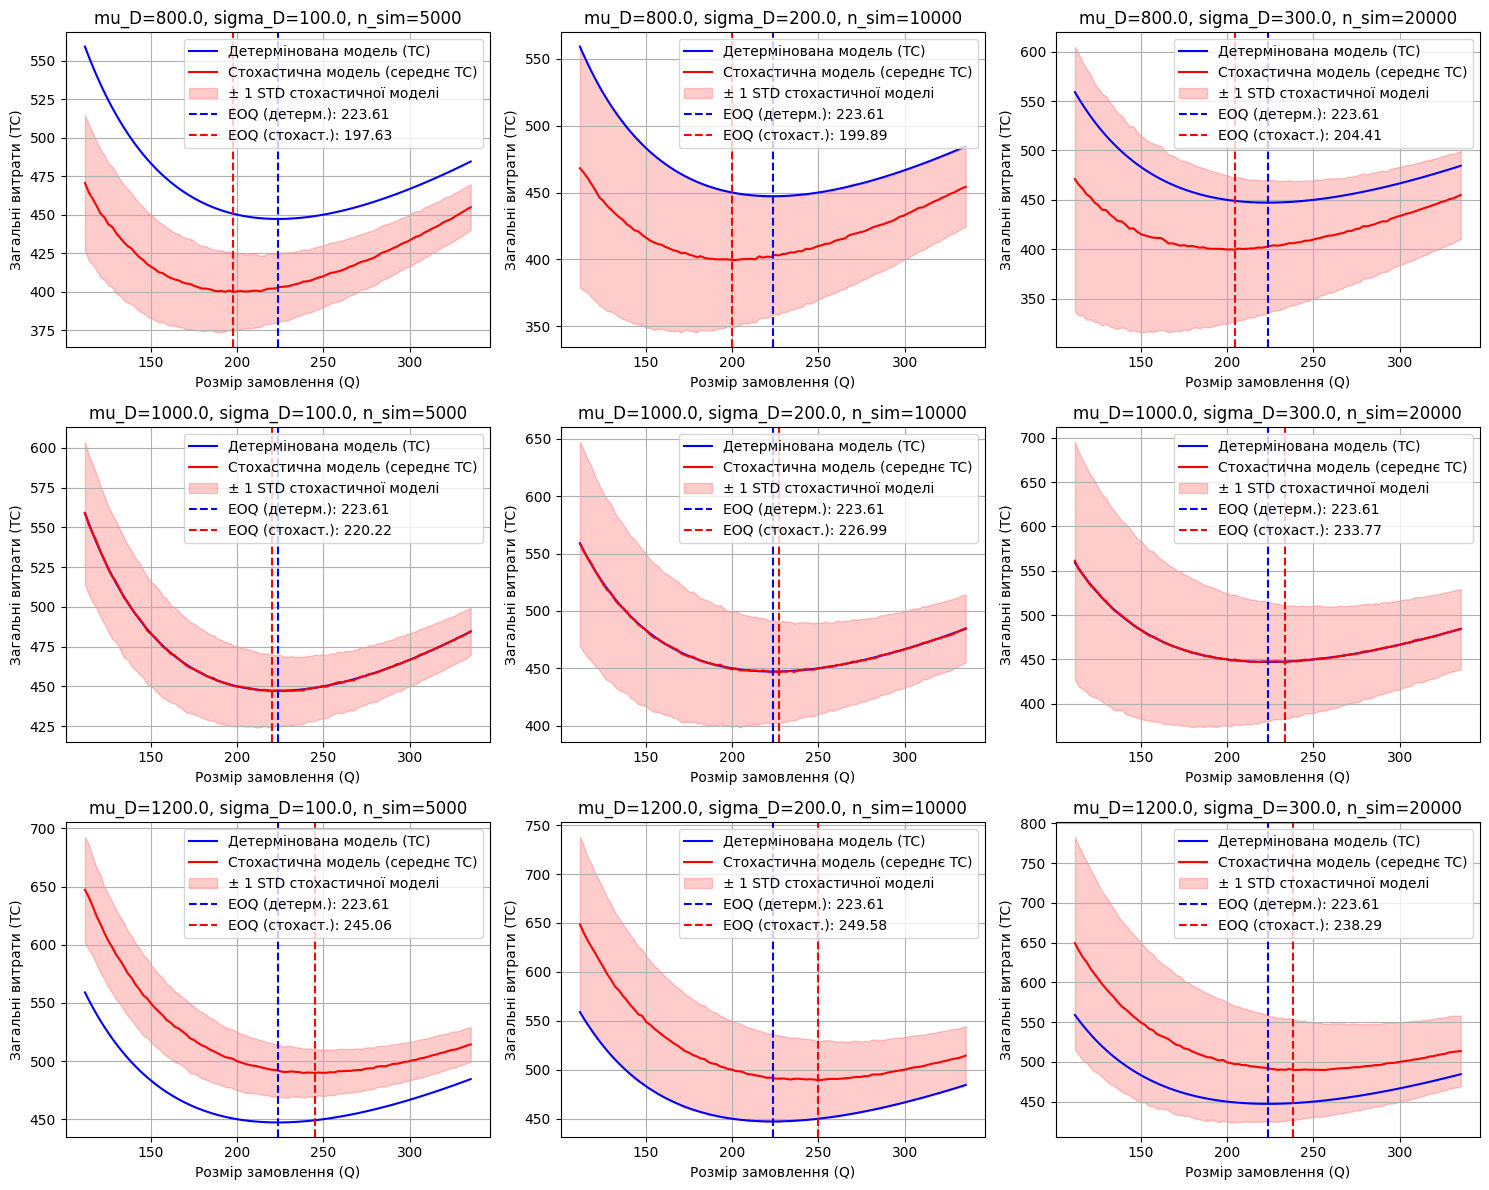

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Детерміновані параметри моделі EOQ
D: float = 1000.0  # Щорічний попит (одиниць продукції)
S: float = 50.0  # Вартість оформлення одного замовлення
H: float = 2.0  # Вартість зберігання одиниці товару за рік

def compute_eoq(D: float, S: float, H: float) -> float:
    """
    Обчислює оптимальну кількість замовлення (EOQ) за формулою:
    Q* = sqrt((2 * D * S) / H)
    """
    return math.sqrt((2 * D * S) / H)

eoq: float = compute_eoq(D, S, H)

def total_cost(Q: float, D: float, S: float, H: float) -> float:
    """
    Обчислює загальні витрати (TC) для заданого розміру замовлення Q:
    TC(Q) = (D / Q) * S + (Q / 2) * H
    """
    return (D / Q) * S + (Q / 2) * H

# Генеруємо значення Q для побудови графіка
Q_values: np.ndarray = np.linspace(eoq * 0.5, eoq * 1.5, 100)
TC_deterministic: np.ndarray = np.array([total_cost(Q, D, S, H) for Q in Q_values])

# Стохастична модифікація: попит є випадковою величиною
# Масиви параметрів для аналізу чутливості
mu_D_values = [800.0, 1000.0, 1200.0]  # Середній попит
sigma_D_values = [100.0, 200.0, 300.0]  # Стандартне відхилення попиту
n_sim_values = [5000, 10000, 20000]  # Кількість симуляцій

# Побудова 9 графіків для різних комбінацій параметрів
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, mu_D in enumerate(mu_D_values):
    for j, sigma_D in enumerate(sigma_D_values):
        n_sim = n_sim_values[j]  # Відповідний рівень симуляцій

        # Обчислення витрат для стохастичної моделі
        TC_stochastic_mean = []
        TC_stochastic_std = []

        for Q in Q_values:
            D_samples = np.maximum(np.random.normal(mu_D, sigma_D, n_sim), 0)
            TC_samples = (D_samples / Q) * S + (Q / 2) * H
            TC_stochastic_mean.append(np.mean(TC_samples))
            TC_stochastic_std.append(np.std(TC_samples))

        TC_stochastic_mean = np.array(TC_stochastic_mean)
        TC_stochastic_std = np.array(TC_stochastic_std)

        # Визначення оптимального значення Q
        optimal_idx_stoch = int(np.argmin(TC_stochastic_mean))
        Q_optimal_stoch = Q_values[optimal_idx_stoch]

        # Вибір осі для поточного графіка
        ax = axes[i, j]

        # Побудова графіка
        ax.plot(Q_values, TC_deterministic, 'b-', label="Детермінована модель (TC)")
        ax.plot(Q_values, TC_stochastic_mean, 'r-', label="Стохастична модель (середнє TC)")
        ax.fill_between(
            Q_values,
            TC_stochastic_mean - TC_stochastic_std,
            TC_stochastic_mean + TC_stochastic_std,
            color='r',
            alpha=0.2,
            label="± 1 STD стохастичної моделі"
        )
        ax.axvline(eoq, color='b', linestyle='--', label=f"EOQ (детерм.): {eoq:.2f}")
        ax.axvline(Q_optimal_stoch, color='r', linestyle='--', label=f"EOQ (стохаст.): {Q_optimal_stoch:.2f}")

        ax.set_xlabel("Розмір замовлення (Q)")
        ax.set_ylabel("Загальні витрати (TC)")
        ax.set_title(f"mu_D={mu_D}, sigma_D={sigma_D}, n_sim={n_sim}")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


**Результати**

* У детермінованій моделі оптимальний розмір замовлення $Q^*$ є постійним.

* У стохастичній моделі середнє оптимальне значення $Q^*$ може відрізнятися залежно від рівня варіації попиту.

* При збільшенні $\sigma_D$ оптимальне $Q$ зміщується, а загальні витрати стають більш розподіленими.

**Вплив невизначеності попиту**

* Високі значення $\sigma_D$ призводять до більшої варіації загальних витрат.

* Для малих $\sigma_D$ стохастична модель наближається до детермінованої.

* При збільшенні $\mu_D$ оптимальне $Q$ збільшується, як і в детермінованому випадку.

* Зі збільшенням $n_{sim}$ середнє значення загальних витрат стає більш стабільним та передбачуваним.

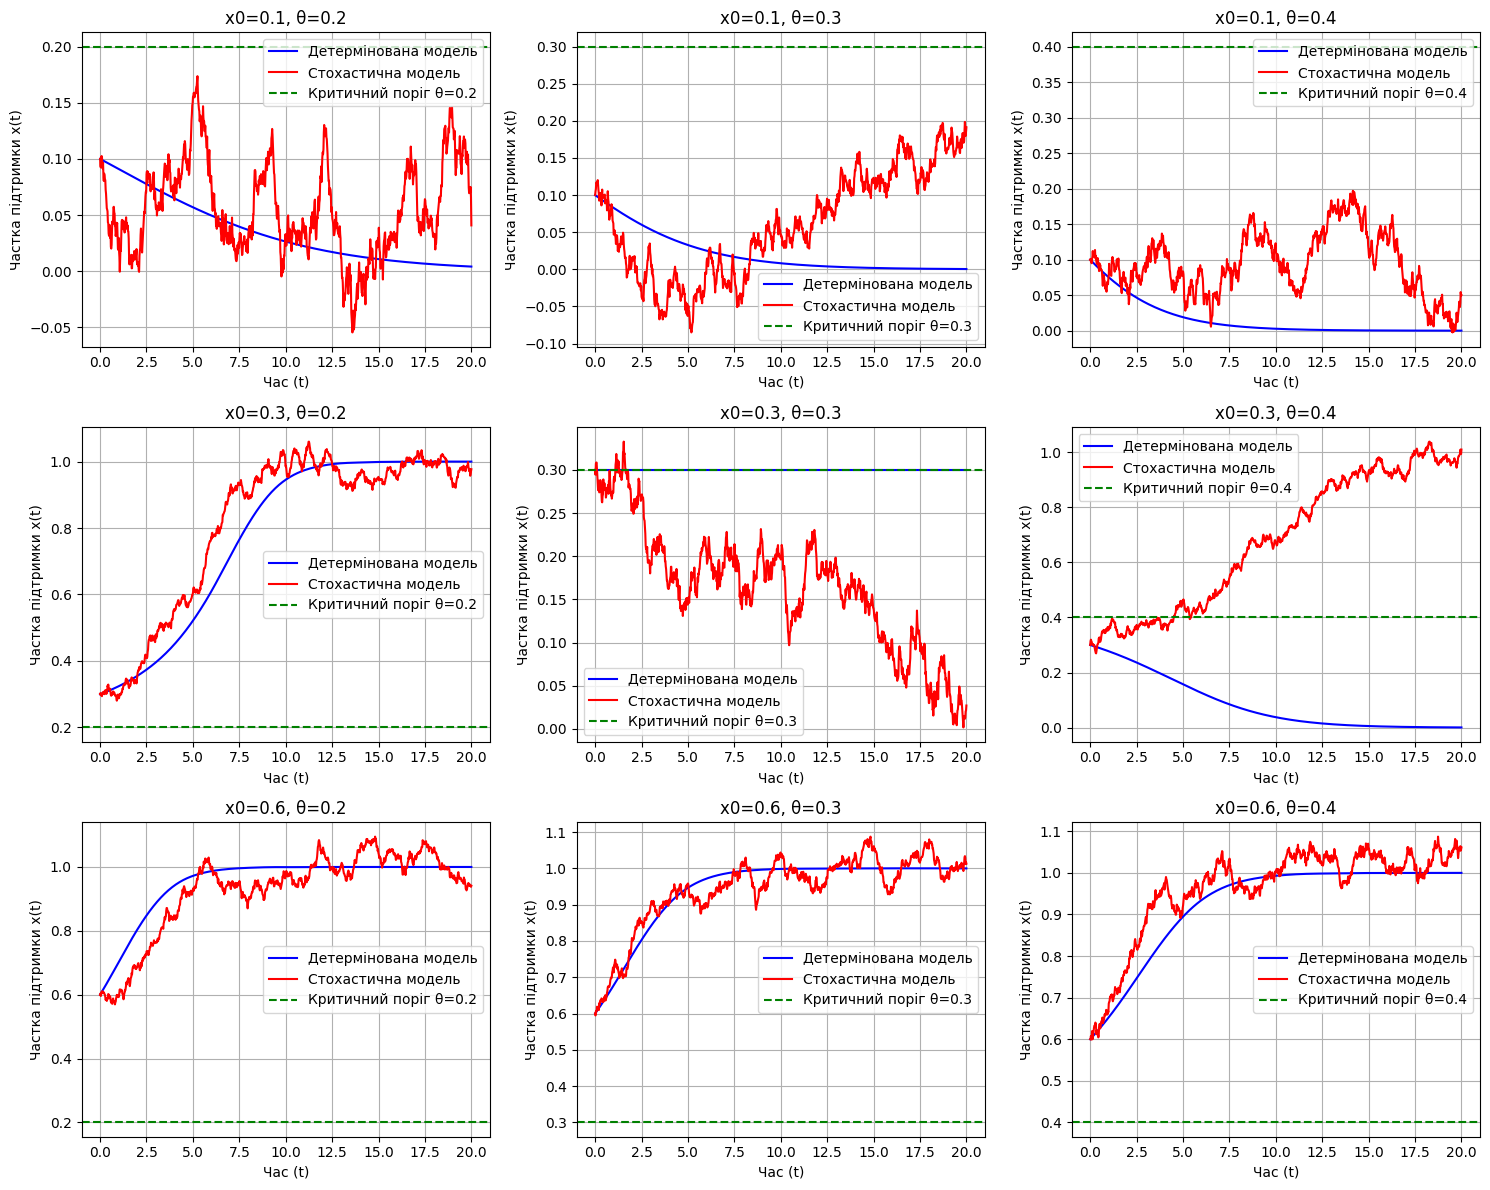

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Визначення параметрів моделі соціальної динаміки (детерміністичної)
k = 1.0  # Коефіцієнт швидкості динаміки
theta = 0.3  # Критичний поріг
x0_values = [0.1, 0.3, 0.6]  # Початкові значення частки населення
theta_values = [0.2, 0.3, 0.4]  # Значення критичного порогу
sigma_noise = 0.05  # Інтенсивність шуму (адитивний шум)

t_span = (0, 20)  # Проміжок часу
t_eval = np.linspace(t_span[0], t_span[1], 300)  # Часовий вектор для розв’язання

# Функція соціальної динаміки (детерміністична)
def social_dynamics(t, x, k, theta):
    return k * x * (1 - x) * (x - theta)

# Побудова 9 графіків для різних комбінацій x0 та theta
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, x0 in enumerate(x0_values):
    for j, theta in enumerate(theta_values):
        # Детерміноване розв’язання
        solution_det = solve_ivp(social_dynamics, t_span, [x0], t_eval=t_eval, args=(k, theta))
        x_det = solution_det.y[0]

        # Стохастична модель соціальної динаміки (Euler–Maruyama)
        n_steps = 1000  # Кількість часових кроків
        T = t_span[1]  # Загальний час моделювання
        dt = T / n_steps  # Крок інтегрування
        t_stoch = np.linspace(t_span[0], T, n_steps)
        x_stoch = np.zeros(n_steps)
        x_stoch[0] = x0  # Початкове значення

        for step in range(1, n_steps):
            dW = np.random.normal(0, np.sqrt(dt))  # Вінерівський процес
            f = k * x_stoch[step-1] * (1 - x_stoch[step-1]) * (x_stoch[step-1] - theta)
            x_stoch[step] = x_stoch[step-1] + f * dt + sigma_noise * dW

        # Вибір осі для поточного графіка
        ax = axes[i, j]

        # Побудова графіка
        ax.plot(t_eval, x_det, 'b-', label="Детермінована модель")
        ax.plot(t_stoch, x_stoch, 'r-', label="Стохастична модель")
        ax.axhline(y=theta, color='g', linestyle='--', label=f"Критичний поріг θ={theta}")

        ax.set_xlabel("Час (t)")
        ax.set_ylabel("Частка підтримки x(t)")
        ax.set_title(f"x0={x0}, θ={theta}")
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


**Вплив початкового значення $x_0$:**

- При малих $x_0$, система може стабілізуватися в нульовому стані (зникнення підтримки ідеї).
- Якщо $x_0$ більше або близьке до $\theta$, система може перейти до стану високої підтримки.

**Вплив критичного порогу $\theta$:**

- Зі збільшенням $\theta$, зона нестабільності розширюється – менше початкових значень $x_0$ призводять до домінування ідеї.
- Якщо $\theta$ високе, підтримка повинна початися з достатньо високого рівня, щоб ідея закріпилася.

**Стохастичний ефект:**

- Шум може спричиняти випадкові флуктуації, що можуть або сприяти переходу до стабільного стану, або, навпаки, спричиняти спад підтримки.
- У деяких випадках стохастична модель демонструє нестійкість, навіть якщо детерміністична версія передбачає стабільний стан.


In [4]:
from typing import Tuple, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

def get_historical_data(
    tickers: List[str],
    start_date: str = "2018-01-01",
    end_date: str = "2023-01-01"
) -> pd.DataFrame:
    """
    Завантажує історичні котирування для заданих тикерів акцій з використанням yfinance.
    Повертає колонку 'Adj Close' (при вимкненому auto_adjust),
    щоб бути сумісним із подальшими розрахунками.
    """
    data = yf.download(
        tickers,
        start=start_date,
        end=end_date,
        auto_adjust=False  # Вимикаємо автоматичне коригування, щоб мати 'Adj Close'
    )["Adj Close"]

    # Якщо завантажено кілька тикерів, `data` буде DataFrame,
    # для одного тикеру — Series. Перетворимо в DataFrame зі стовпцями за тикерами.
    if len(tickers) == 1:
        data = data.to_frame(tickers[0])
    return data

def calculate_annual_return_and_volatility(
    prices: pd.DataFrame
) -> Tuple[pd.Series, pd.Series]:
    """
    Обчислює річну доходність та річну волатильність (стандартне відхилення)
    на основі щоденних цін закриття (prices).
    Повертає кортеж (annual_returns, annual_volatility).
    """
    # Обчислимо щоденні лог-доходності
    daily_returns = np.log(prices / prices.shift(1)).dropna()

    # Середня щоденна лог-доходність
    mean_daily_returns = daily_returns.mean()
    # Стандартне відхилення щоденної лог-доходності
    std_daily_returns = daily_returns.std()

    # Переводимо щоденний показник у річний (припускаючи ~252 торгових дні)
    annual_returns = mean_daily_returns * 252
    annual_volatility = std_daily_returns * np.sqrt(252)

    return annual_returns, annual_volatility

def monte_carlo_portfolio_simulation(
    annual_returns: pd.Series,
    annual_volatility: pd.Series,
    weights: List[float],
    n_simulations: int = 10_000
) -> np.ndarray:
    """
    Виконує Монте-Карло симуляції для портфеля з кількох активів,
    припускаючи нормальний розподіл доходностей.

    :param annual_returns: Річні доходності (очікування) для кожного активу.
    :param annual_volatility: Річні волатильності (std) для кожного активу.
    :param weights: Список із n ваг (сума має бути 1).
    :param n_simulations: Кількість симуляцій.
    :return: Масив змодельованих річних доходностей портфеля.
    """
    n_assets = len(annual_returns)
    if len(weights) != n_assets:
        raise ValueError("Кількість ваг не відповідає кількості активів.")

    # Перетворимо серії в NumPy-масиви
    means = annual_returns.values
    stds = annual_volatility.values
    w = np.array(weights)

    # Результуючий масив для збереження доходностей портфеля
    portfolio_returns = np.zeros(n_simulations)

    for i in range(n_simulations):
        # Симулюємо випадкову річну доходність для кожного активу
        simulated_returns = np.random.normal(loc=means, scale=stds, size=n_assets)
        # Портфельна доходність
        portfolio_returns[i] = np.sum(w * simulated_returns)

    return portfolio_returns

def compute_value_at_risk(
    returns: np.ndarray,
    alpha: float = 0.05
) -> float:
    """
    Обчислює Value-at-Risk (VaR) на рівні alpha.
    Емпіричний підхід через квантиль: np.percentile.

    :param returns: Масив портфельних доходностей (Монте-Карло або історичні).
    :param alpha: Ризик-рівень (наприклад, 0.05 для 5% VaR).
    :return: VaR на рівні alpha.
    """
    return np.percentile(returns, 100 * alpha)

[*********************100%***********************]  3 of 3 completed

Отримано дані форми: (1259, 3)


Ticker,GM,GOOG,TSLA
Date,,,
2018-01-02,37.113682,53.059353,21.368668
2018-01-03,38.019329,53.930225,21.150000
2018-01-04,39.191341,54.125519,20.974667
2018-01-05,39.075912,54.914188,21.105333
2018-01-08,39.262379,55.148846,22.427334



Річні доходності (очікування), %:
Ticker
GM      -2.389127
GOOG    10.228241
TSLA    35.090118
dtype: float64

Річна волатильність (std), %:
Ticker
GM      41.949891
GOOG    31.381880
TSLA    65.450953
dtype: float64

Очікувана дохідність портфеля (середнє): 12.87%
Ризик портфеля (стандартне відхилення): 27.40%
Value-at-Risk (5%): -32.68%


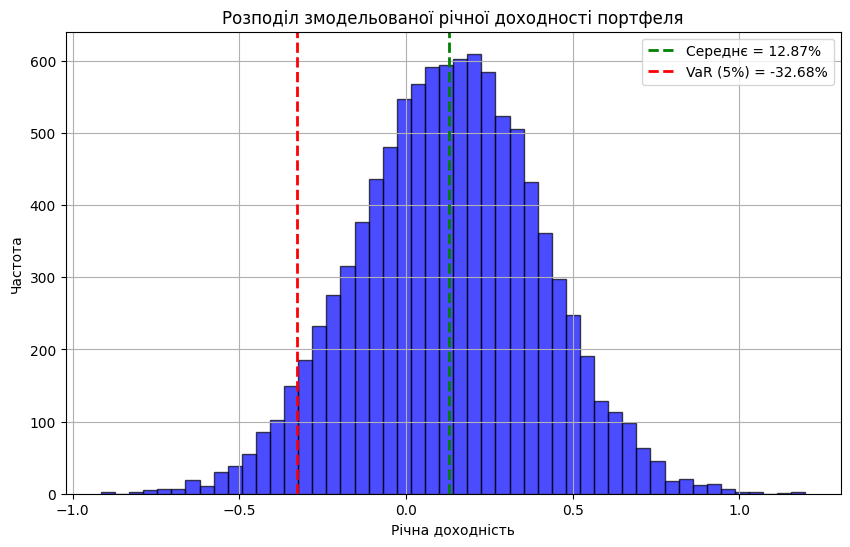

In [5]:
# 1. Збір та обробка даних
tickers = ["TSLA", "GOOG", "GM"]
data = get_historical_data(tickers, start_date="2018-01-01", end_date="2023-01-01")

print(f"Отримано дані форми: {data.shape}")
display(data.head())

# 2. Розрахунок річної доходності та волатильності
annual_returns, annual_volatility = calculate_annual_return_and_volatility(data)
print("\nРічні доходності (очікування), %:")
print(annual_returns * 100)
print("\nРічна волатильність (std), %:")
print(annual_volatility * 100)

# 3. Симуляція портфельної доходності
# Приклад ваг: сума має дорівнювати 1.
weights = [0.4, 0.3, 0.3]
n_simulations = 10_000

simulated_portfolio_returns = monte_carlo_portfolio_simulation(
    annual_returns=annual_returns,
    annual_volatility=annual_volatility,
    weights=weights,
    n_simulations=n_simulations
)

# 4. Обчислення показників
expected_return = np.mean(simulated_portfolio_returns)
portfolio_risk = np.std(simulated_portfolio_returns)
var_5 = compute_value_at_risk(simulated_portfolio_returns, alpha=0.05)

print(f"\nОчікувана дохідність портфеля (середнє): {expected_return:.2%}")
print(f"Ризик портфеля (стандартне відхилення): {portfolio_risk:.2%}")
print(f"Value-at-Risk (5%): {var_5:.2%}")

# 5. Візуалізація
plt.figure(figsize=(10, 6))
plt.hist(simulated_portfolio_returns, bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(expected_return, color='green', linestyle='dashed', linewidth=2,
            label=f'Середнє = {expected_return:.2%}')
plt.axvline(var_5, color='red', linestyle='dashed', linewidth=2,
            label=f'VaR (5%) = {var_5:.2%}')

plt.title("Розподіл змодельованої річної доходності портфеля")
plt.xlabel("Річна доходність")
plt.ylabel("Частота")
plt.legend()
plt.grid(True)
plt.show()

**Висновки:**
* Висока дохідність, але значні коливання.
* GM тягне портфель вниз.
* Великий ризик через частку Tesla.

### Які обмеження має метод Монте-Карло для оцінки портфельної доходності?
Результати дуже чутливі до припущень про розподіли доходностей, кореляції між активами та інші параметри. Якщо ці припущення некоректні або застарілі, оцінка може бути неточною. Також часто симуляції базуються на попреденіх даних, які можуть не відобразити майбутніх змін у ринкових умовах, структурних зрушеннях чи рідкісних подіях.

### Які інші методи можна використовувати для аналізу та управління портфелем?
* Метод Марковіца, який допомагає знаходити оптимальне співвідношення ризику та доходності.
* Факторний аналіз для розбиття доходності на вплив окремих факторів.

### Чи можна використовувати інші розподіли ймовірностей для моделювання доходностей активів, крім нормального? Які аргументи за та проти?
**t-розподіл**
* **За:** 1. t-розподіл краще відображає екстремальні події, що часто спостерігаються на фінансових ринках. 2. Кількість ступенів свободи є регульованим параметром, що дозволяє адаптувати модель під конкретні дані. При меншій кількості ступенів свободи хвости стають важчими, а при збільшенні t-розподіл наближається до нормального.
* **Проти:** оцінка ступенів свободи та інших параметрів може бути складною, особливо при обмеженій кількості даних. Невірне налаштування може призвести до помилкових висновків.

**Розподіл гамма**
* **За:** розподіл ґамма є асиметричним і може бути корисним для моделювання доходностей, які мають природну асиметрію (наприклад, коли доходності не можуть бути від'ємними).
* **Проти:** Оскільки доходності активів можуть бути як позитивними, так і негативними, використання розподілу ґамма, який визначений лише для додатних значень, може бути обмежуючим. Для подолання цього обмеження часто застосовують перетворення даних, що може ускладнити інтерпретацію.

### Як врахувати невизначеність щодо майбутніх доходностей активів?
**Баєсівські підходи:** використання баєсівських методів для інтеграції невизначеності в параметри моделей, що дозволяє оновлювати оцінки за мірою надходження нової інформації.

**Моделі з умовними розподілами:** наприклад, GARCH моделі або інші часові моделі, які адаптуються до змін волатильності в часі.

### Які існують альтернативні методи оцінки ризику, крім VaR?
**Conditional Value at Risk (CVaR) / Expected Shortfall**

Оцінює середні збитки у найгірших випадках, що може дати кращу картину ризику у порівнянні з VaR.

**Моделі з урахуванням максимального просідання (Maximum Drawdown)**

Оцінюють найбільше падіння вартості портфеля від піку до найнижчого значення, що допомагає виміряти екстремальні втрати протягом певного періоду.

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -------------------------------------------------------------
# 1. Генерація синтетичного часового ряду
# -------------------------------------------------------------

np.random.seed(42)  # Фіксуємо seed для відтворюваності результатів

n = 2000  # кількість спостережень
dates = pd.date_range(start='2020-01-01', periods=n, freq='D')

# Параметри для формування даних
trend = 0.01  # лінійний тренд
season_period = 7  # тиждень
amplitude = 5      # амплітуда сезонних коливань
noise_std = 2      # стандартне відхилення випадкового шуму

# Створюємо базове значення, що зростає з трендом
time_index = np.arange(n)
baseline = 50 + trend * time_index

# Додаємо сезонну складову (синусоїда з періодом 7)
seasonal = amplitude * np.sin(2 * np.pi * time_index / season_period)

# Формуємо підсумковий ряд і додаємо шум
noise = np.random.normal(loc=0, scale=noise_std, size=n)
ts_data = baseline + seasonal + noise

# Збираємо все в DataFrame
df = pd.DataFrame({'value': ts_data}, index=dates)
df.index.name = 'Date'

# Подивимося на перші 5 рядків
print(df.head())

                value
Date                 
2020-01-01  50.993428
2020-01-02  53.642629
2020-01-03  56.190017
2020-01-04  55.245478
2020-01-05  47.402275


In [7]:
# -------------------------------------------------------------
# 2. Фітинг моделі ARIMA
# -------------------------------------------------------------

p, d, q = 2, 1, 4

arima_model = ARIMA(df['value'], order=(p, d, q))
arima_result = arima_model.fit()
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 2000
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -4255.080
Date:                Mon, 03 Mar 2025   AIC                           8524.161
Time:                        16:15:35   BIC                           8563.364
Sample:                    01-01-2020   HQIC                          8538.556
                         - 06-22-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2469      0.000   6853.846      0.000       1.247       1.247
ar.L2         -0.9998      0.000  -7059.366      0.000      -1.000      -1.000
ma.L1         -2.2023      0.023    -95.352      0.0

C:\Users\marym\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# -------------------------------------------------------------
# 2.1 Фітинг моделі SARIMA
# -------------------------------------------------------------

p, d, q = 1, 1, 1
P, D, Q, m = 1, 0, 1, 7  # тиждень - сезонний період 7

sarima_model = SARIMAX(df['value'], order=(p, d, q),
                       seasonal_order=(P, D, Q, m),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 2000
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4207.730
Date:                           Mon, 03 Mar 2025   AIC                           8425.461
Time:                                   16:15:41   BIC                           8453.440
Sample:                               01-01-2020   HQIC                          8435.737
                                    - 06-22-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0097      0.023     -0.428      0.669      -0.054       0.035
ma.L1         -1.0000      0.486     -2.056

In [9]:
# -------------------------------------------------------------
# 3. Прогнозування на 20 днів
# -------------------------------------------------------------

T = 70

# ARIMA forecast
arima_forecast = arima_result.get_forecast(steps=T)
arima_pred = arima_forecast.predicted_mean
arima_conf = arima_forecast.conf_int()

# SARIMA forecast
sarima_forecast = sarima_result.get_forecast(steps=T)
sarima_pred = sarima_forecast.predicted_mean
sarima_conf = sarima_forecast.conf_int()

# Створимо DataFrame з прогнозами
future_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=T, freq='D')

forecast_df = pd.DataFrame({
    'ARIMA_forecast': arima_pred.values,
    'SARIMA_forecast': sarima_pred.values
}, index=future_dates)

print(forecast_df)


            ARIMA_forecast  SARIMA_forecast
2025-06-23       65.514436        65.405137
2025-06-24       66.395839        66.337767
2025-06-25       70.133758        70.247180
2025-06-26       73.884990        73.965306
2025-06-27       74.825024        74.847393
...                    ...              ...
2025-08-27       70.134285        70.871914
2025-08-28       73.864257        74.586262
2025-08-29       74.798646        75.467453
2025-08-30       72.234399        73.026662
2025-08-31       68.102906        68.488927

[70 rows x 2 columns]


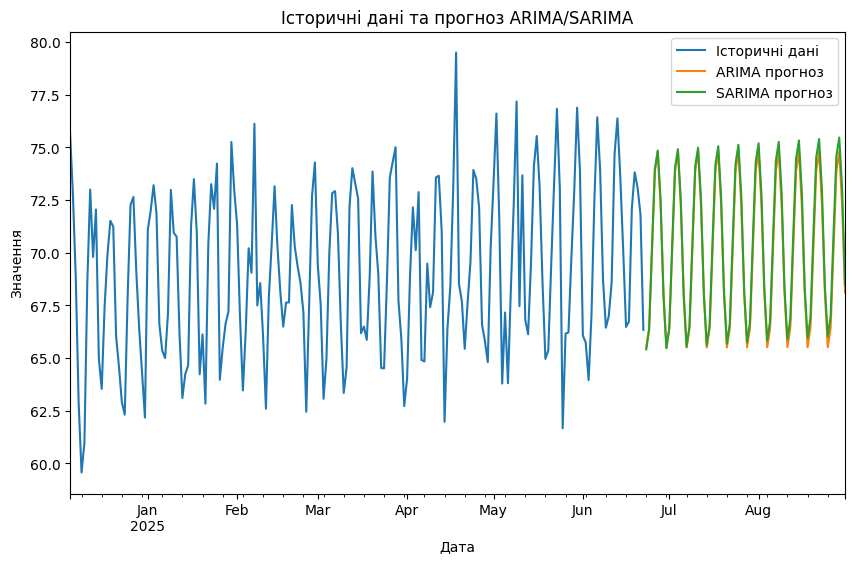

In [10]:
# -------------------------------------------------------------
# 4. Візуалізація
# -------------------------------------------------------------

plt.figure(figsize=(10, 6))

# Останні 100 днів історії
history_length = 200
df['value'].iloc[-history_length:].plot(label='Історичні дані')

# ARIMA прогноз
arima_pred.plot(label='ARIMA прогноз')

# SARIMA прогноз
sarima_pred.plot(label='SARIMA прогноз')

plt.title('Історичні дані та прогноз ARIMA/SARIMA')
plt.xlabel('Дата')
plt.ylabel('Значення')
plt.legend()
plt.show()


# Аналіз даних та прогнозу ARIMA/SARIMA

## 1. Тренди, сезонність, автокореляція
- **Тренд**: Чіткого довгострокового тренду немає, дані коливаються навколо середнього рівня.
- **Сезонність**: Виражена тижнева (період 7 днів), яку краще захоплює SARIMA (зелені “хвилі”).
- **Автокореляція**: Значні AR/MA-складові свідчать про внутрішню залежність між значеннями ряду.

## 2. Застосування прогнозу
- **Бюджетування**: Планування витрат і доходів з урахуванням сезонних піків/спадів.
- **Виробництво**: Розподіл ресурсів і запасів під “хвильову” динаміку попиту/пропозиції.
- **Управління ризиками**: Оцінка “що, якщо” при відхиленнях від прогнозу.

## 3. Відмінність моделей
- **ARIMA (p,d,q)**: Краща, коли сезонність слабка або неявна.
- **SARIMA (p,d,q)(P,D,Q)m**: Додає явні сезонні компоненти, корисна при регулярних циклах (наприклад, тижневих).
